# import and adjust data & set hyperparameters

In [1]:
#import data
import pandas as pd 
data=pd.read_csv('yelp_sentence_price.csv',encoding = 'ISO-8859-1')
for i in range(len(data['sentences'])):
    data['sentences'][i]=data['sentences'][i].replace('?','')
data.head()

/Users/aoxu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Unnamed: 0,sentences,single_label,multi_label,scale(0-5),scale(1-3)
0,0,"First off I made reservations for 9:30, we cam...",service,service,1.0,1
1,1,"Finally were seated around 9:40, but no that w...",service,service,2.0,1
2,2,The tables are very tightly packed but the amb...,environment,environment,3.0,2
3,3,"We did the falafal for an app, it looked diffe...",taste,taste,3.0,2
4,4,We also ordered some wine and the chicken duo ...,na,na,0.0,2


In [2]:
len(data)

1548

In [3]:
#delete the row if length of sentences is smaller than 2
l=[]
for i in range(len(data['sentences'])):
    if len(data['sentences'][i])<=2:
        l.append(i)
print(l)

[101, 776, 788, 800, 805, 806, 946, 1143]


In [4]:
data_drop=data.drop(l)

In [5]:
data_new=data_drop.reset_index(drop=True)

In [6]:
data_new=data_new[0:1135]

In [7]:
# Prepocessing data: Tokenize, pad sentences

from keras.preprocessing.text import Tokenizer

# get a Keras tokenizer
# https://keras.io/preprocessing/text/
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_new["sentences"])

/Users/aoxu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# CNN--use sample data

In [9]:
#CNN Model
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
              
def cnn_model(FILTER_SIZES, \
              # filter sizes as a list
              MAX_NB_WORDS, \
              # total number of words
              MAX_DOC_LEN, \
              # max words in a doc
              EMBEDDING_DIM=200, \
              # word vector dimension
              NUM_FILTERS=64, \
              # number of filters for all size
              DROP_OUT=0.5, \
              # dropout rate
              NUM_OUTPUT_UNITS=1, \
              # number of output units
              NUM_DENSE_UNITS=100,\
              # number of units in dense layer
              PRETRAINED_WORD_VECTOR=None,\
              # Whether to use pretrained word vectors
              LAM=0.0):            
              # regularization coefficient
    
    main_input = Input(shape=(MAX_DOC_LEN,), \
                       dtype='int32', name='main_input')
    
    if PRETRAINED_WORD_VECTOR is not None:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        weights=[PRETRAINED_WORD_VECTOR],\
                        trainable=False,\
                        name='embedding')(main_input)
    else:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        name='embedding')(main_input)
    # add convolution-pooling-flat block
    conv_blocks = []
    for f in FILTER_SIZES:
        conv = Conv1D(filters=NUM_FILTERS, kernel_size=f, \
                      activation='relu', name='conv_'+str(f))(embed_1)
        conv = MaxPooling1D(MAX_DOC_LEN-f+1, name='max_'+str(f))(conv)
        conv = Flatten(name='flat_'+str(f))(conv)
        conv_blocks.append(conv)
    
    if len(conv_blocks)>1:
        z=Concatenate(name='concate')(conv_blocks)
    else:
        z=conv_blocks[0]
        
    drop=Dropout(rate=DROP_OUT, name='dropout')(z)

    dense = Dense(NUM_DENSE_UNITS, activation='relu',\
                    kernel_regularizer=l2(LAM),name='dense')(drop)
    preds = Dense(NUM_OUTPUT_UNITS, activation='sigmoid', name='output')(dense)
    model = Model(inputs=main_input, outputs=preds)
    
    model.compile(loss="binary_crossentropy", \
              optimizer="adam", metrics=["accuracy"]) 
    
    return model

In [10]:
#seperate labels into list of list
l1=[]
for i in range(len(data_new['multi_label'])):
    if len(data_new['multi_label'][i].split(','))==1:
        l1.append(data_new['multi_label'][i].split(','))
    else:
        l1.append(data_new['multi_label'][i].split(','))
l1

[['service'],
 ['service'],
 ['environment'],
 ['taste'],
 ['na'],
 ['service'],
 ['na'],
 ['service'],
 ['taste'],
 ['taste'],
 ['na'],
 ['taste'],
 ['na'],
 ['price'],
 ['taste'],
 ['service'],
 ['na'],
 ['environment', 'service'],
 ['service'],
 ['na'],
 ['na'],
 ['na'],
 ['service'],
 ['service'],
 ['service'],
 ['environment'],
 ['service'],
 ['environment'],
 ['taste'],
 ['na'],
 ['na'],
 ['na'],
 ['taste'],
 ['na'],
 ['service'],
 ['service'],
 ['service'],
 ['service'],
 ['service'],
 ['taste'],
 ['taste'],
 ['na'],
 ['taste'],
 ['na'],
 ['taste'],
 ['service'],
 ['environment', 'service', 'taste'],
 ['taste'],
 ['environment', 'service'],
 ['service'],
 ['service'],
 ['price', 'service'],
 ['environment'],
 ['taste'],
 ['environment'],
 ['service'],
 ['service'],
 ['na'],
 ['service'],
 ['taste'],
 ['taste'],
 ['na'],
 ['service'],
 ['taste'],
 ['taste'],
 ['na'],
 ['taste'],
 ['na'],
 ['service'],
 ['price'],
 ['na'],
 ['environment', 'service'],
 ['environment'],
 ['taste'],

In [11]:
#prepare multi_label data
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
text=list(data_new['sentences'])
labels=l1
mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(labels)
# check size of indicator matrix
Y.shape
# check classes
print(labels[1])
print(mlb.classes_)
# check # of samples in each class
np.sum(Y, axis=0)

['service']
['environment' 'na' 'price' 'service' 'taste']


array([100, 382,  60, 239, 433])

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
 
import numpy as np

# get a Keras tokenizer

MAX_NB_WORDS=8000
# documents are quite long in the dataset
MAX_DOC_LEN=1000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text)
voc=tokenizer.word_index
# convert each document to a list of word index as a sequence
sequences = tokenizer.texts_to_sequences(text)
# get the mapping between words to word index

# pad all sequences into the same length (the longest)
padded_sequences = pad_sequences(sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', truncating='post')

In [13]:
print(padded_sequences.shape)
print(Y.shape)

(1135, 1000)
(1135, 5)


In [14]:
# Exercise 5.7.4: Fit the model using the function

from sklearn.model_selection import train_test_split
BEST_MODEL_FILEPATH="best_model"
EMBEDDING_DIM=100
FILTER_SIZES=[2,3,4]

# set the number of output units
# as the number of classes
output_units_num=len(mlb.classes_)
num_filters=64

# set the dense units
dense_units_num= num_filters*len(FILTER_SIZES)


BTACH_SIZE = 64
NUM_EPOCHES = 20

# split dataset into train (70%) and test sets (30%)
X_train, X_test, Y_train, Y_test = train_test_split(\
                padded_sequences, Y, test_size=0.2, random_state=0)


model=cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                MAX_DOC_LEN, \
                NUM_FILTERS=num_filters,\
                NUM_OUTPUT_UNITS=output_units_num, \
                NUM_DENSE_UNITS=dense_units_num)

earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', \
                             verbose=2, save_best_only=True, mode='min')
    
training=model.fit(X_train, Y_train, \
          batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
          callbacks=[earlyStopping, checkpoint],\
          validation_data=[X_test, Y_test], verbose=2)

Train on 908 samples, validate on 227 samples
Epoch 1/20
 - 31s - loss: 0.5785 - acc: 0.7575 - val_loss: 0.4656 - val_acc: 0.7868

Epoch 00001: val_loss improved from inf to 0.46556, saving model to best_model
Epoch 2/20
 - 29s - loss: 0.4739 - acc: 0.7872 - val_loss: 0.4527 - val_acc: 0.7868

Epoch 00002: val_loss improved from 0.46556 to 0.45266, saving model to best_model
Epoch 3/20
 - 29s - loss: 0.4601 - acc: 0.7872 - val_loss: 0.4451 - val_acc: 0.7868

Epoch 00003: val_loss improved from 0.45266 to 0.44514, saving model to best_model
Epoch 4/20
 - 29s - loss: 0.4383 - acc: 0.7967 - val_loss: 0.4315 - val_acc: 0.7956

Epoch 00004: val_loss improved from 0.44514 to 0.43150, saving model to best_model
Epoch 5/20
 - 29s - loss: 0.4063 - acc: 0.8335 - val_loss: 0.4131 - val_acc: 0.8167

Epoch 00005: val_loss improved from 0.43150 to 0.41311, saving model to best_model
Epoch 6/20
 - 29s - loss: 0.3500 - acc: 0.8672 - val_loss: 0.3852 - val_acc: 0.8441

Epoch 00006: val_loss improved fr

In [32]:
model.load_weights("best_model")

pred=model.predict(X_test)
pred[0:5]

array([[0.10271314, 0.04442211, 0.04879505, 0.02944866, 0.9344251 ],
       [0.17941195, 0.72551835, 0.11403948, 0.11928127, 0.16167894],
       [0.1356639 , 0.6211164 , 0.06953127, 0.07578795, 0.21489926],
       [0.06720914, 0.17669109, 0.02552224, 0.01134211, 0.82146615],
       [0.12710385, 0.29139104, 0.04838203, 0.06866771, 0.31995416]],
      dtype=float32)

In [33]:
from sklearn.metrics import classification_report
pred=np.where(pred>0.5,1,0)
print(classification_report(Y_test,pred,target_names=mlb.classes_))

             precision    recall  f1-score   support

environment       0.00      0.00      0.00        20
         na       0.59      0.57      0.58        69
      price       0.00      0.00      0.00         9
    service       0.90      0.47      0.62        40
      taste       0.79      0.74      0.77       104

avg / total       0.66      0.56      0.60       242



/Users/aoxu/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# CNN---pretrained word-vector---yelp review from Kaggle

In [15]:
import pandas as pd
yelp=pd.read_csv('yelp_Kaggle.csv')
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [16]:
import nltk
import string
text_yelp=list(yelp['text'])
sentences=[ [token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc) \
                 if token not in string.punctuation and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in text_yelp]

In [17]:
#Train word vector using 
# the large data set

from gensim.models import word2vec
import logging
import pandas as pd

# print out tracking information
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
                    level=logging.INFO)
EMBEDDING_DIM=200
# min_count: words with total frequency lower than this are ignored
# size: the dimension of word vector
# window: is the maximum distance 
#         between the current and predicted word 
#         within a sentence (i.e. the length of ngrams)
# workers: # of parallel threads in training
# for other parameters, check https://radimrehurek.com/gensim/models/word2vec.html
wv_model = word2vec.Word2Vec(sentences, min_count=5, \
                             size=EMBEDDING_DIM, window=5, workers=4 )

2018-04-24 19:43:48,605 : INFO : collecting all words and their counts
2018-04-24 19:43:48,607 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-24 19:43:48,982 : INFO : collected 41630 word types from a corpus of 1237749 raw words and 10000 sentences
2018-04-24 19:43:48,984 : INFO : Loading a fresh vocabulary
2018-04-24 19:43:49,043 : INFO : min_count=5 retains 10987 unique words (26% of original 41630, drops 30643)
2018-04-24 19:43:49,045 : INFO : min_count=5 leaves 1190767 word corpus (96% of original 1237749, drops 46982)
2018-04-24 19:43:49,092 : INFO : deleting the raw counts dictionary of 41630 items
2018-04-24 19:43:49,095 : INFO : sample=0.001 downsamples 56 most-common words
2018-04-24 19:43:49,097 : INFO : downsampling leaves estimated 922341 word corpus (77.5% of prior 1190767)
2018-04-24 19:43:49,148 : INFO : estimated required memory for 10987 words and 200 dimensions: 23072700 bytes
2018-04-24 19:43:49,150 : INFO : resetting layer weights

In [18]:
# get word vector for all words in the vocabulary

EMBEDDING_DIM=200
MAX_NB_WORDS=2825

# tokenizer.word_index provides the mapping 
# between a word and word index for all words
NUM_WORDS = min(MAX_NB_WORDS, len(tokenizer.word_index))

# "+1" is for padding symbol
embedding_matrix = np.zeros((NUM_WORDS+1, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    # if word_index is above the max number of words, ignore it
    if i >= NUM_WORDS:
        continue
    if word in wv_model.wv:
        embedding_matrix[i]=wv_model.wv[word]

In [19]:
# Exercise 5.8.3: Fit model using pretrained word vectors

from sklearn.model_selection import train_test_split

EMBEDDING_DIM=200
FILTER_SIZES=[2,3,4]

# set the number of output units
# as the number of classes
output_units_num=len(mlb.classes_)

#Number of filters for each size
num_filters=64

# set the dense units
dense_units_num= num_filters*len(FILTER_SIZES)

BTACH_SIZE = 32
NUM_EPOCHES = 100

# With well trained word vectors, sample size can be reduced
# Assume we only have 500 labeled data
# split dataset into train (70%) and test sets (20%)

X_train, X_test, Y_train, Y_test = train_test_split(\
                padded_sequences, Y, \
                test_size=0.2, random_state=0, shuffle=True)

# create the model with embedding matrix
model=cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                MAX_DOC_LEN, \
                NUM_FILTERS=num_filters,\
                NUM_OUTPUT_UNITS=output_units_num, \
                NUM_DENSE_UNITS=dense_units_num,\
                PRETRAINED_WORD_VECTOR=embedding_matrix)

earlyStopping=EarlyStopping(monitor='val_loss', patience=1, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', \
                             verbose=2, save_best_only=True, mode='min')
    
training=model.fit(X_train, Y_train, \
          batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
          callbacks=[earlyStopping, checkpoint],\
          validation_data=[X_test, Y_test], verbose=2)

Train on 908 samples, validate on 227 samples
Epoch 1/100
 - 22s - loss: 0.5209 - acc: 0.7758 - val_loss: 0.4027 - val_acc: 0.8326

Epoch 00001: val_loss improved from inf to 0.40266, saving model to best_model
Epoch 2/100
 - 22s - loss: 0.4279 - acc: 0.8104 - val_loss: 0.3740 - val_acc: 0.8493

Epoch 00002: val_loss improved from 0.40266 to 0.37402, saving model to best_model
Epoch 3/100
 - 21s - loss: 0.3892 - acc: 0.8330 - val_loss: 0.3588 - val_acc: 0.8573

Epoch 00003: val_loss improved from 0.37402 to 0.35875, saving model to best_model
Epoch 4/100
 - 21s - loss: 0.3524 - acc: 0.8537 - val_loss: 0.3310 - val_acc: 0.8758

Epoch 00004: val_loss improved from 0.35875 to 0.33101, saving model to best_model
Epoch 5/100
 - 21s - loss: 0.3288 - acc: 0.8667 - val_loss: 0.3241 - val_acc: 0.8714

Epoch 00005: val_loss improved from 0.33101 to 0.32414, saving model to best_model
Epoch 6/100
 - 21s - loss: 0.3226 - acc: 0.8689 - val_loss: 0.3331 - val_acc: 0.8670

Epoch 00006: val_loss did n

In [20]:
from sklearn.metrics import classification_report
pred=model.predict(padded_sequences)

Y_pred=np.copy(pred)
Y_pred=np.where(Y_pred>0.5,1,0)

Y_pred[0:10]

print(classification_report(Y, Y_pred, target_names=mlb.classes_))

             precision    recall  f1-score   support

environment       0.89      0.39      0.54       100
         na       0.91      0.55      0.68       382
      price       0.71      0.42      0.53        60
    service       0.78      0.79      0.79       239
      taste       0.80      0.88      0.84       433

avg / total       0.83      0.69      0.74      1214



# input new data and label automatically 

In [21]:
### restaurant morimoto ###
import pandas as pd 
review18=pd.read_csv('yelp_review 2018.csv',encoding = 'ISO-8859-1')
review17=pd.read_csv('yelp_review_2017.csv',encoding = 'ISO-8859-1')
match=review18[review18['name']=='Morimoto'].append(review17[review17['name']=='Morimoto'])


In [22]:
match_re=match.reset_index(drop=True)

In [23]:
match_re.head()

,date,star,review,name
0,2/17/2018,5.0 star rating,This place was really nice. Let's start with t...,Morimoto
1,2/17/2018,2.0 star rating,I had high hopes going here after looking at t...,Morimoto
2,2/16/2018,5.0 star rating,Visited October 2017 for date night with my hu...,Morimoto
3,2/16/2018,4.0 star rating,Came here with a reservation for a Wednesday l...,Morimoto
4,2/14/2018,4.0 star rating,"Ambience was really nice, however they sat us ...",Morimoto


In [24]:
sen=''
for i in range(len(match_re['review'])):
    sen=sen+match_re['review'][i]
sen

'This place was really nice. Let\'s start with the food. If your not sure what to order, ?appetizers must try there Toro Tartare, Bone Marrow, & wagyu Beef Carpaccio. We also ordered their Chelsea Market oysters which is common. Nice and fresh. For your main entree must try their Sea Urchin Uni, Scallop and Hotate Otoro Nigiri & their Duck Duck Goose! For dessert we got the Lava Bomb and the Matcha. They make really good martinis of which I ordered the Lychee Martini. Great wine selection as well and beer Asahi. I know this all seems a lot but it is worth it for a night out in a fancy restaurant There service was great. Every dish was introduced upon serving & you were always served with a fresh clean plate. The ambience is great. U are able to hear each other with out having to worry about music being to loud. Great for a date or business dinner meeting or just a night out with friends to socialize.I had high hopes going here after looking at the menu. It was definitely pricey but fig

In [26]:
from nltk import tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

sentence=tokenize.sent_tokenize(sen)
sen_new=[i for i in sentence if len(i)>2]
sentence

['This place was really nice.',
 "Let's start with the food.",
 'If your not sure what to order, ?appetizers must try there Toro Tartare, Bone Marrow, & wagyu Beef Carpaccio.',
 'We also ordered their Chelsea Market oysters which is common.',
 'Nice and fresh.',
 'For your main entree must try their Sea Urchin Uni, Scallop and Hotate Otoro Nigiri & their Duck Duck Goose!',
 'For dessert we got the Lava Bomb and the Matcha.',
 'They make really good martinis of which I ordered the Lychee Martini.',
 'Great wine selection as well and beer Asahi.',
 'I know this all seems a lot but it is worth it for a night out in a fancy restaurant There service was great.',
 'Every dish was introduced upon serving & you were always served with a fresh clean plate.',
 'The ambience is great.',
 'U are able to hear each other with out having to worry about music being to loud.',
 'Great for a date or business dinner meeting or just a night out with friends to socialize.I had high hopes going here after l

In [27]:
#clean data and build padded_sequence

# get a Keras tokenizer

MAX_NB_WORDS=8000
# documents are quite long in the dataset
MAX_DOC_LEN=1000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(sen_new)
voc=tokenizer.word_index
# convert each document to a list of word index as a sequence
sequences = tokenizer.texts_to_sequences(sen_new)
# get the mapping between words to word index

# pad all sequences into the same length (the longest)
padded_sequences = pad_sequences(sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', truncating='post')

In [28]:
model.load_weights("best_model")
pred=model.predict(padded_sequences[0:600])

Y_pred=np.copy(pred)
Y_pred=np.where(Y_pred>0.3,1,0)

Y_pred[0:10]

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 1, 1]])

In [ ]:
#scale prediction
df2=pd.DataFrame(Y_pred,columns=mlb.classes_)
df2.head()

In [29]:
df=pd.DataFrame(Y_pred,columns=mlb.classes_)
df.head()

,environment,na,price,service,taste
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,0,1
3,0,1,0,0,1
4,0,1,0,0,0


In [30]:
list_sen=[[i] for i in sen_new]
df1=pd.DataFrame(list_sen,columns=['review'])
df1.head()

,review
0,This place was really nice.
1,Let's start with the food.
2,"If your not sure what to order, ?appetizers mu..."
3,We also ordered their Chelsea Market oysters w...
4,Nice and fresh.


In [31]:
df1.columns=['sentences']

In [32]:
len(df1)

366

In [33]:
result = pd.concat([df, df1], axis=1)
result.head()

,environment,na,price,service,taste,sentences
0,0,1,0,0,0,This place was really nice.
1,0,1,0,0,0,Let's start with the food.
2,0,0,0,0,1,"If your not sure what to order, ?appetizers mu..."
3,0,1,0,0,1,We also ordered their Chelsea Market oysters w...
4,0,1,0,0,0,Nice and fresh.


In [35]:
len(result)

366

In [37]:
text=list(data_new['sentences'])

labels1 = data_new['scale(1-3)'].tolist()
labels1 = [str(i) for i in labels1]
mlb = MultiLabelBinarizer()
Y1=mlb.fit_transform(labels1)

print(mlb.classes_)


['1' '2' '3']


In [38]:
MAX_NB_WORDS=8000
# documents are quite long in the dataset
MAX_DOC_LEN=1000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text)
voc=tokenizer.word_index
# convert each document to a list of word index as a sequence
sequences = tokenizer.texts_to_sequences(text)
# get the mapping between words to word index

# pad all sequences into the same length (the longest)
padded_sequences = pad_sequences(sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', truncating='post')

In [39]:
BEST_MODEL_FILEPATH="best_model"
EMBEDDING_DIM=100
FILTER_SIZES=[2,3,4]

# set the number of output units
# as the number of classes
output_units_num=3
num_filters=64

# set the dense units
dense_units_num= num_filters*len(FILTER_SIZES)


BTACH_SIZE = 64
NUM_EPOCHES = 20


X_train, X_test, Y_train1, Y_test1 = train_test_split(padded_sequences, Y1, test_size=0.2, random_state=0)

model=cnn_model(FILTER_SIZES, MAX_NB_WORDS, MAX_DOC_LEN, NUM_FILTERS=num_filters,\
                NUM_OUTPUT_UNITS=output_units_num, \
                NUM_DENSE_UNITS=dense_units_num)

earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', \
                             verbose=2, save_best_only=True, mode='min')
    
training=model.fit(X_train, Y_train1, \
          batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
          callbacks=[earlyStopping, checkpoint],\
          validation_data=[X_test, Y_test1], verbose=2)

Train on 908 samples, validate on 227 samples
Epoch 1/20
 - 32s - loss: 0.6484 - acc: 0.6468 - val_loss: 0.6227 - val_acc: 0.6667

Epoch 00001: val_loss improved from inf to 0.62269, saving model to best_model
Epoch 2/20
 - 31s - loss: 0.6184 - acc: 0.6674 - val_loss: 0.6168 - val_acc: 0.6667

Epoch 00002: val_loss improved from 0.62269 to 0.61682, saving model to best_model
Epoch 3/20
 - 29s - loss: 0.5947 - acc: 0.6714 - val_loss: 0.6053 - val_acc: 0.6725

Epoch 00003: val_loss improved from 0.61682 to 0.60531, saving model to best_model
Epoch 4/20
 - 29s - loss: 0.5455 - acc: 0.7280 - val_loss: 0.5783 - val_acc: 0.7093

Epoch 00004: val_loss improved from 0.60531 to 0.57828, saving model to best_model
Epoch 5/20
 - 29s - loss: 0.4444 - acc: 0.8201 - val_loss: 0.5435 - val_acc: 0.7166

Epoch 00005: val_loss improved from 0.57828 to 0.54350, saving model to best_model
Epoch 6/20
 - 29s - loss: 0.3231 - acc: 0.8858 - val_loss: 0.5422 - val_acc: 0.7269

Epoch 00006: val_loss improved fr

In [41]:
MAX_NB_WORDS=8000

MAX_NB_WORDS=1000

text = list(result['sentences'])

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text)
voc=tokenizer.word_index

sequences = tokenizer.texts_to_sequences(text)
padded_sequences = pad_sequences(sequences, maxlen=MAX_DOC_LEN, padding='post', truncating='post')

In [42]:
model.load_weights("best_model")

pred=model.predict(padded_sequences)

In [114]:
pred=np.where(pred>0.5,1,0)
scale = pd.DataFrame(pred,columns=mlb.classes_)

In [116]:
data_set = pd.concat([result,scale],axis=1)


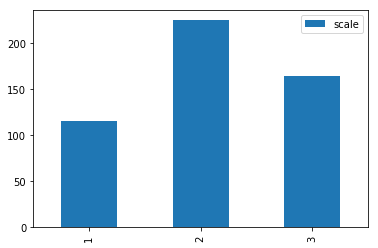

In [128]:
pd.DataFrame(np.sum(data_set[['1','2','3']],axis=0),columns=['scale']).plot(kind='bar')

In [79]:
np.average(np.average(scale[scale['taste']==1][['1','2','3']],axis=0))

0.6777777777777777

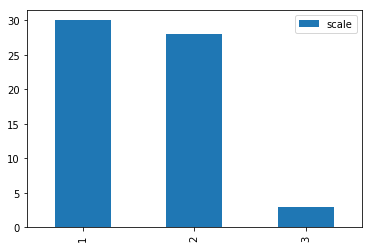

In [93]:
%matplotlib inline
pd.DataFrame(np.sum(scale[scale['taste']==1][['sentences','1','2','3']],axis=0),columns=['scale']).iloc[1:].plot(kind='bar')

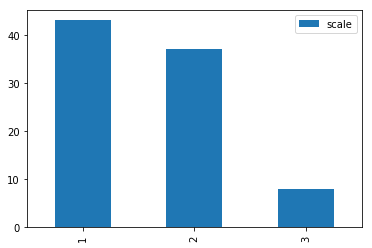

In [94]:
pd.DataFrame(np.sum(scale[scale['service']==1][['sentences','1','2','3']],axis=0),columns=['scale']).iloc[1:].plot(kind='bar')

In [72]:
scale=data_set[data_set["1"]==1]
taste=scale[scale['taste']==1]

,environment,na,price,service,taste,sentences,1,2,3
10,0,0,0,1,1,Every dish was introduced upon serving & you w...,1,1,0
14,0,1,0,0,1,It was definitely pricey but figured with a he...,1,1,0
23,0,0,0,0,1,"My sushi roll was just a sushi roll, nothing s...",1,1,0
76,0,1,0,0,1,I ordered the sashimi set which came with 10 p...,1,1,0
77,0,0,0,0,1,Omakase in the city usually costs a pretty pen...,1,1,0
79,0,1,0,0,1,"I was however, impressed by the dessert I orde...",1,1,0
104,0,0,0,0,1,?One of the sides was miso soup.,1,1,0
108,0,1,0,0,1,The area is elegantly decorated with a modern ...,1,1,0
128,0,0,0,0,1,I had the sushi as maki and the quality of the...,1,1,0
172,0,0,0,1,1,This is for those days when you want to splurg...,1,1,0


In [71]:
service['sentences'][220]

"We were put in a corner where the decor wasn't even close to being ok."